In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from qbraid_algorithms.QTran import  *
from qbraid_algorithms.QFT_2 import  *
from qbraid_algorithms.amplitude_amplification import *
import pyqasm as pq

<div class="alert alert-block alert-info">
<h1>QasmBuilder Demo</h6>

QasmBuilder is a small tool to help build out algorithms within the qbraid algorithms package. <br>
It is a macroed string builder at heart which exposes development at all levels of abstraction, <br>
and is a QOL feature. Its patterns can be pierced at any point in time and development if the <br>
overhead is too much. This comes at minimal cost to system QOL benefits like easy import and <br>
ancilla tracking, with the only risk being the lack of guarantee of programmatic correctness of <br>
developer added code
***
This notebook looks to demonstrate the package structure and the design patterns first expected <br>
from this package

</div>


<b>QOL items this package provides:</b><br>
RESOURCE MANAGEMENT:<br>

- Use claim_qubits() and claim_clbits() for dynamic allocation
- Track resource usage across library imports
- Ensure proper cleanup of scope levels before building

ERROR HANDLING:<br>

- All builders check for unclosed scopes before generation
- Invalid gate references are caught during library operations
- Resource conflicts are handled through the allocation system


<div class="alert alert-block alert-success">
<b>Here is a short demo of the power of the QasmBuilder library before diving deeper</b> 
</div>

OPENQASM 3;
include "stdgates.inc";
qubit[5] qb;
bit[5] cb;
h qb[1];
/*
This is a 
Multi-line comment
*/
//Single line comment
for int i in [0:4] {
	x qb[i];
	//Inside loop
}
cb[{1}] = measure qb[{1}];



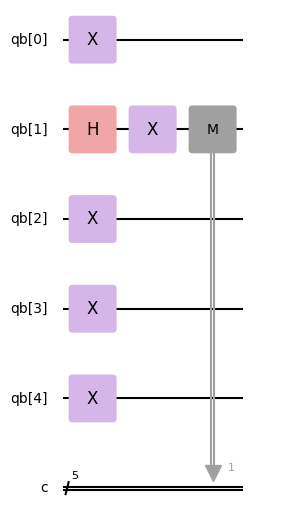

In [3]:
# Create 10-qubit circuit with OpenQASM 3.0
alg = QasmBuilder(5, version="3") 
register = [*range(5)]

# Import standard gates library
program = alg.import_library(std_gates)

# Import QFT library
qft = alg.import_library(QFTLibrary)

# Apply gates
program.h(1)                           # X gate on qubit 1
program.comment("This is a \nMulti-line comment")  # Add documentation
program.comment("Single line comment") # More documentation

# Loop example
program.begin_loop(5)                  # Loop 5 times
program.x("i")                     # X gate using loop variable (default i)
program.comment("Inside loop")     # Scoped comment
program.end_loop()                     # End loop
# qft.QFT(register[:5])
# Measurement
program.measure([1], [1])              # Measure qubit 1 → classical bit 1

prog = alg.build()
print(prog)
res = pq.loads(prog)
pq.draw(res)
        

<div class="alert alert-block alert-info">
<h1>The QasmBuilder Object</h6>
</div>

This library provides a flexible framework for generating OpenQASM code through a hierarchical builder pattern. Built on top of the root FileBuilder class which separates text content from structure/semantics requirements unique to each file type.

**Key Features:**
- Automatic scope and indentation management
- Library import and gate definition tracking  
- Multiple output formats (QASM circuits, includes, gate definitions)
- Resource allocation for qubits and classical bits
- Extensible design for custom quantum libraries

**Class Extensions:** GateBuilder, QasmBuilder, IncludeBuilder

### Typical Usage Patterns:

#### 1. Complete Quantum Circuit
```python
builder = QasmBuilder(qubits=5, clbits=5)
gates = builder.import_library(std_gates)
gates.h(0)
gates.cx(0, 1)
circuit_code = builder.build()
```

#### 2. Gate Library Development  
```python
builder = GateBuilder()
gates = builder.import_library(std_gates)
# Define custom gates...
program, imports, definitions = builder.build()
```

#### 3. Include File Creation
```python
builder = IncludeBuilder()
# Add gate definitions and utilities...
include_content = builder.build()
with open("custom.inc", 'w') as f:
    f.write(include_content)
```

<div class="alert alert-block alert-info">
<h1>The GateLibrary Object</h6>
</div>

GateLibrary is a base framework for macroing gate, import, and algorithm generation and is                                                 
built to inject definitions into whatever FileBuilder class it is connected to.

Key (Base) Features:                                             
- Gate application with controls and phases                             
- Measurements and classical bit operations                             
- Control flow (loops, conditionals)                                    
- Gate and subroutine definitions                                       
- Code generation and scope management 

Class Extensions:
- std_gates


### GATELIBRARY OBJECT TYPICAL USAGE PATTERNS:


##### standard gate applications:
The most common way a gatelibary is used to to directly correlate to applying a gate either from a static call <br>
to an import library like std_gates, or to a more dynamic gate generator for more bulky components like QFT to <br>
the top of the file where only a few gate types are used (import generator is currently a stub but should allow <br> 
for the sequestering of these components to import files themselves local to the main algorithm)

The following is a demo of one of the more complex dynamic gate calls:

In [ ]:
alg = QasmBuilder(5,version="3") 
qft = alg.import_library(QFTLibrary)


#call QFT gate
qft.QFT([*range(4)])



prog = alg.build()
res = pq.loads(prog)
print(res)

OPENQASM 3.0;
include "stdgates.inc";
qubit[5] qb;
bit[5] cb;
gate QFT4S aa, ab, ac, ad {
  h aa;
  cp(pi / 2) aa, ab;
  cp(pi / 4) aa, ac;
  cp(pi / 8) aa, ad;
  h ab;
  cp(pi / 2) ab, ac;
  cp(pi / 4) ab, ad;
  h ac;
  cp(pi / 2) ac, ad;
  h ad;
  swap ad, aa;
  swap ac, ab;
}
QFT4S qb[0], qb[1], qb[2], qb[3];



##### Blind/ Closure applications
many algorithms provide advantage through being agnostic to the application of another component such as the <br> 
inner workings of a Hamiltonian. Thus passing the Hamilitonian (or other compenent) to a generator is a workflow<br>
currently near completion. This interface uses the hamiltonian as a gatebuilder object itself, and has some <br>
stricter requirements for application, first there are three methods which are needed depending on the <br>
generator: apply, unapply (inverse), and controlled (apply/unapply). for the most part, this lets generators <br>
agnostically work with the component but sometimes generators absolutely must need a gated version of the  <br>
component to work with (this is expected to be fixed in later revisions). Further work is also expected to <br>
bring selective annotation to the output generation and have most generators result in gates rather than sub- <br>
routines.

lastly for these closures, there tends to be some customizability to the level of interface with the generators <br>
by default, the generators will blindly call apply to the hamiltonian but arguments passed to the generator which <br>
allow for further parameters to be prepended to the Hamil call (ie having phase estimation set an evolution time <br>
for the Hamiltonian will have it pass a time t as the first argument in apply). You must setup your closure to  <br>
accept these parameters. 

the following is a demo of a grovers search algorithm with a blind application of an index hamiltonian:

In [5]:
# Create 10-qubit circuit with OpenQASM 3.0
alg = QasmBuilder(5, version="3") 
reg = [*range(5)]

# Import standard gates library
program = alg.import_library(std_gates)

# Import Amplitude amplification library
ampl = alg.import_library(AALibrary)

class Za(GateLibrary):
    name = "Z_on_two"
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.name = "Z_on_two"
        self.call_space = "{}"

    def apply(self,qubits):
        sys = self.builder
        std = sys.import_library(std_gates)
        ind = dict(zip(range(len(qubits)),qubits))
        ind.pop(2)
        self.controlled_op("cp",(qubits[2],list(ind.values())),n=len(qubits)-2)

ampl.Grover(Za,reg,2)

prog = alg.build()
print(prog)
res = pq.loads(prog)

OPENQASM 3;
include "stdgates.inc";
qubit[5] qb;
bit[5] cb;
def Grover5Z_on_two2(qubit[5] reg) {
	h  reg;
	for int i in [0:1] {
		//Za
		ctrl(3) @ cp reg[0],reg[1],reg[3],reg[4],reg[2];
		h  reg;
		//Z0
		x  reg;
		ctrl(4) @ z  reg[0], reg[1], reg[2], reg[3], reg[0];
		x  reg;
		h  reg;
	}
}

 Grover5Z_on_two2(qb[{0 ,1 ,2 ,3 ,4}]);



<div class="alert alert-block alert-warning">
<h1>Some Hang Ups</h1>
</div>

### Loop Syntax in Quantum Gate Library
Loop syntax is quite diverse and thus the macro generator accepts several different parameterizations for generation, along with some extended capture syntax for working with loop variables. The following section explains several different ways a loop can be called.

#### 1. Simple Integer Loops
The most basic loop form takes a single integer and creates a range from 0 to that number (exclusive).

```python
gates.begin_loop(5)     # Creates: for int i in [0:5]
gates.h("i")            # Apply Hadamard to qubits 0,1,2,3,4
gates.end_loop()
```

#### 2. Range Loops with Start and End
Use a tuple `(start, end)` to specify custom ranges.

```python
gates.begin_loop((2, 7))  # Creates: for int i in [2:7]
gates.x("i")              # Apply X to qubits 2,3,4,5,6
gates.end_loop()
```

#### 3. Stepped Loops
Use a tuple `(start, step, end)` for custom step sizes and directions.

```python
gates.begin_loop((0, 2, 8))  # Creates: for int i in [0:8:2]
gates.z("i")                 # Apply Z to qubits 0,2,4,6
gates.end_loop()
```

#### 4. Floating-Point Loops
For algorithms requiring continuous parameters, use float ranges with `(start, step_value, count)`.

```python
gates.begin_loop((0.0, 0.5, 4))  # Creates float range with 4 values
gates.phase("i", 1)              # Use loop variable as phase parameter
gates.end_loop()
```

#### 5. Custom Type and Domain Loops
For maximum flexibility, specify both type and domain explicitly using `(type_string, domain_string)`.

```python
gates.begin_loop(("uint", "[1:2:8]"))  # Creates: for uint i in [1:2:8]
gates.sx("i")
gates.end_loop()
```

#### 6. Direct OpenQASM Syntax
For complete control, pass raw OpenQASM loop syntax as a string.

```python
gates.begin_loop("bit b in {0, 1}")     # Custom boolean loop
gates.x(0)                              # Operations inside loop
gates.end_loop()
```

## Loop Parameter Summary

| Pattern | Syntax | Generated OpenQASM | Use Case |
|---------|--------|-------------------|----------|
| Simple | `begin_loop(5)` | `for int i in [0:5]` | Basic iteration |
| Range | `begin_loop((2,7))` | `for int i in [2:7]` | Custom start/end |
| Stepped | `begin_loop((0,2,8))` | `for int i in [0:8:2]` | Skip iterations |
| Float | `begin_loop((0.0,0.5,4))` | `for float i in {...}` | Continuous params |
| Custom | `begin_loop(("uint","[1:8]"))` | `for uint i in [1:8]` | Type control |
| Direct | `begin_loop("custom syntax")` | `for custom syntax` | Full control |